# Python implementation of MOPS 
This is a python implementation of the "classical" Moving Object Processing algorithm (e.g. Kubica et al. 2007)
Implemented for LSST-DM by S. Eggl, University of Washington, 2019.

In [1]:
# Pandas dataframes
import pandas as pd
# Accelerators
import numpy as np
import numba
# Execution timer
import time
# MOPS routines
import mops as mops
# JPL Horizons data query
from astroquery.jplhorizons import Horizons
#Clustering
import scipy.spatial as scsp
import sklearn.cluster as cluster
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 40, 'linewidths':0}

In [2]:
def plot_clusters(data, algorithm, args, kwds):
    """Cluster and plot data with skit learn algorithm """
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    plt.figure(dpi=300)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

In [3]:
def plot_clusters3d(data, dims, algorithm, args, kwds):
    """Cluster and plot multi dimensional data with skit learn algorithm
        Plotting is done in 3D only,"""
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    fig=plt.figure(dpi=300,figsize=(20,14))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(data.T[dims[0]], data.T[dims[1]], data.T[dims[2]], c=colors)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    frame = plt.gca()
    #frame.axes.get_xaxis().set_visible(False)
    #frame.axes.get_yaxis().set_visible(False)
    
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=22)
    #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=10)

In [4]:

def metrics(df,pairs,cluster):
    #cluster names (beware: -1 is the cluster of all the leftovers)
    unique_labels = np.unique(cluster.labels_)
    #number of clusters
    n_clusters = len(unique_labels)
    
    #which objects do observations in pairs (tracklets) belong to
    p = np.array(pairs)              
    pair_obj = np.array([df['obj'][p[:,0]].values,df['obj'][p[:,1]].values]).T
    #which pairs (tracklets) belong to the same objects?
    correct = mops.correct_pairs(df,pairs)
    #if a pair is correct pair_ok==1 otherwise 0
    pair_ok = np.zeros(len(cluster.labels_))
    pair_ok[correct] = 1

    #group original observation dataframe by objects
    gdf=df.groupby(['obj'])
    
    #cluster contains all observations of one object
    perfect_clusters =0 
    #cluster contains observations of one object only
    pure_clusters = 0
    #cluster contains all observations of one object + pollution
    valid_clusters = 0
    #cluster contains all observations of more than one object
    impure_clusters = 0
    
    obj_in_cluster=[]
    obj_in_cluster_add=obj_in_cluster.append
    #cluster contains 
    for u in unique_labels:
        #which indices in pair array appear in a given cluster?
        idx = np.where(cluster.labels_ == u)[0]
        #find unique object ids in cluster
        uniq_obj=np.unique(pair_obj[idx])
        
        obj_in_cluster_add(uniq_obj)
        
        if (np.sum(pair_ok[idx]) == len(idx)):
            perfect_clusters += 1
        elif (len(uniq_obj) == 1):
            pure_clusters += 1 
        elif (len(uniq_obj) > 1):
            impure_clusters += 1 
        
            #find unique observation ids in cluster
            uniq_obs=np.rint(np.unique(p[idx]))
      
            #find observation ids linked with objects
            valid=False
            for obj in uniq_obj:
                obs_obj=gdf.indices[obj]
                if(all(np.isin(obs_obj,uniq_obs))):
                    valid=True
            if(valid):
                valid_clusters += 1    
    #number of unique found objects in clusters vs number of actual objects
    n_obj=len(gdf)
    uoc=np.unique(np.hstack(obj_in_cluster[1:]))
    completeness=len(uoc)/n_obj*100
    #objects not found
    obj_in_sample=list(gdf.indices.keys())
    obj_not_found=np.ma.array(obj_in_sample, mask=np.isin(obj_in_sample,uoc))
    
    return [n_obj, n_clusters, perfect_clusters, pure_clusters, impure_clusters, valid_clusters,completeness, obj_not_found, unique_labels, obj_in_cluster]                     


In [56]:
#Get asteroid observations
obs=[]
obs_app=obs.append
for i in np.arange(1,101):
    obj = Horizons(id=i, location='I11',
                epochs={'start':'2019-01-01', 'stop':'2019-01-20',
                        'step':'1d'})
    eph = obj.ephemerides()
    arr=len(eph['RA'])
    num=np.full(arr,i)
    
    obs_app(np.array([num,eph['datetime_jd'],eph['RA'],eph['DEC']]))


In [59]:
# Convert observations to pandas dataframe
obsa=np.array(obs)
df=pd.DataFrame(np.hstack(obsa).T,columns=['obj','time','RA','DEC'])

In [60]:
# Transform RADEC observations into positions on the unit sphere (US)
xyz=mops.radec2icrfu(df['RA'],df['DEC'],deg=True)
posu=np.array([xyz[0],xyz[1],xyz[2]]).T

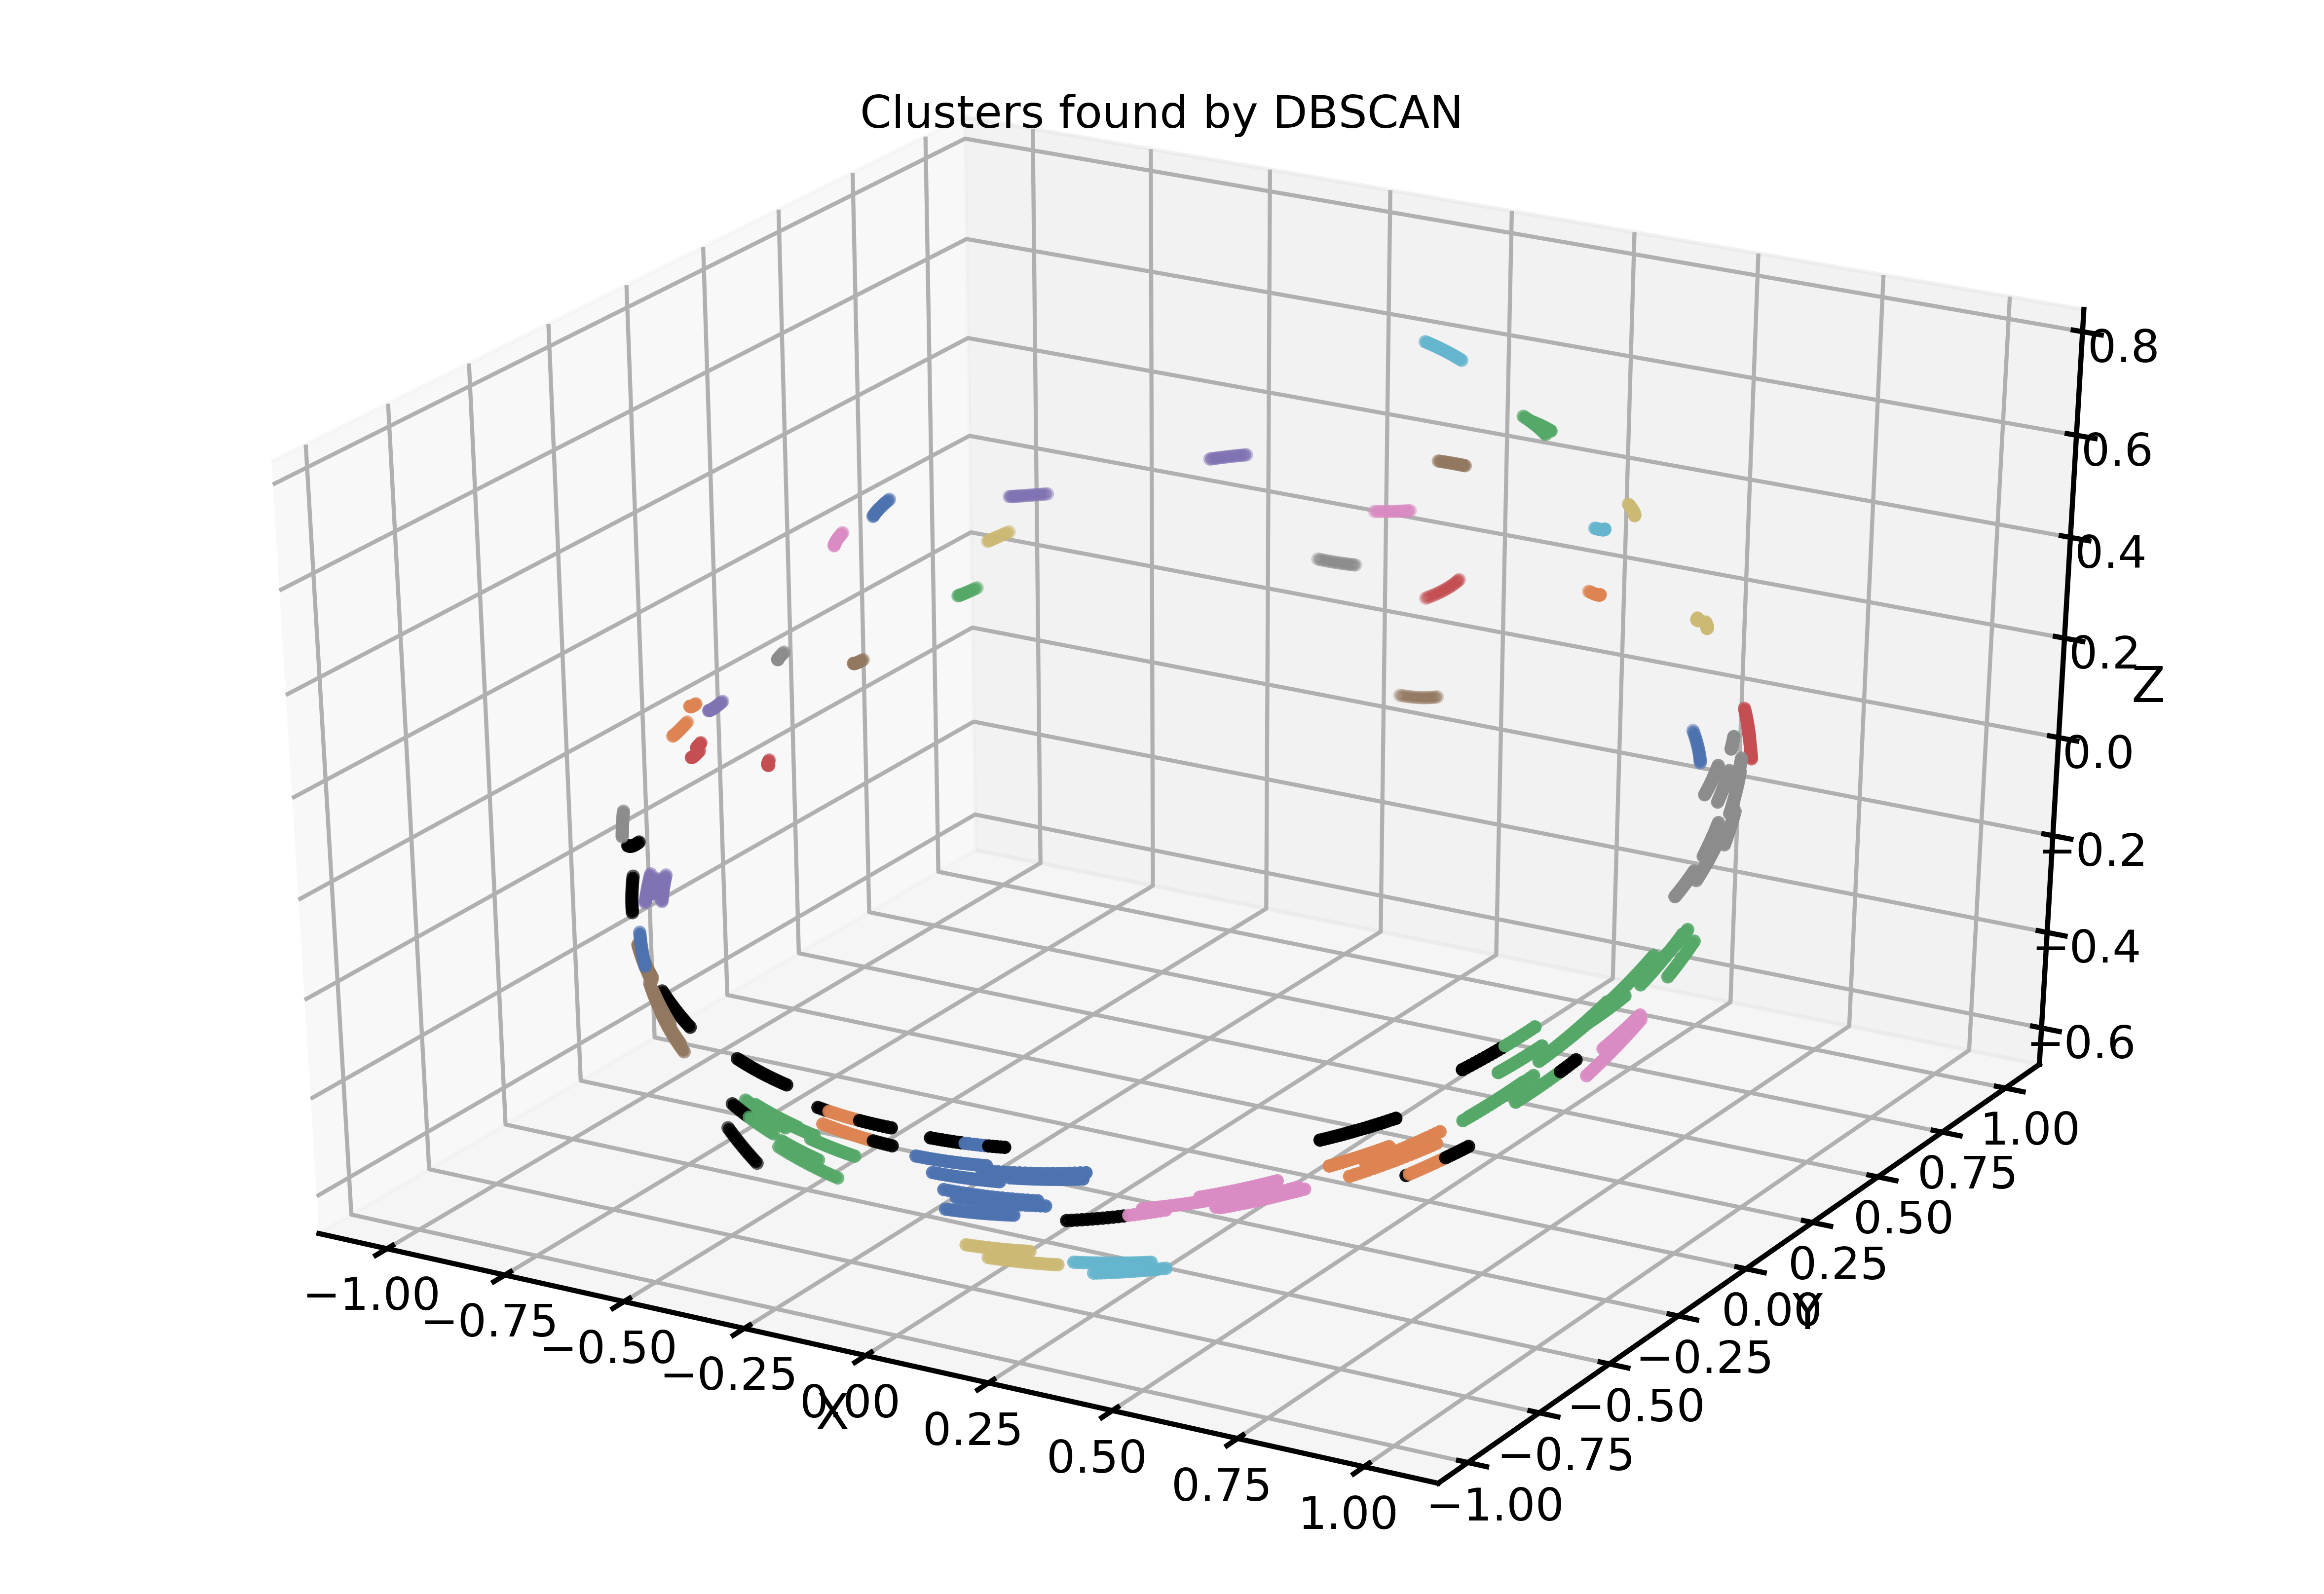

In [62]:
# Try clustering on the positions on the US
plot_clusters3d(posu,[0,1,2], cluster.DBSCAN, (), {'eps':0.05,'min_samples':20})

### Not so great... dbscan either clusters too many nearby observations of unrelated objects (large eps) or doesn't find objects at all (small eps)

### So we build your KDTree and try the trick with tracklet arrows from HelioLinC


In [63]:
[xarrow, varrow, tarrow, goodpairs] = mops.create_arrows(df)

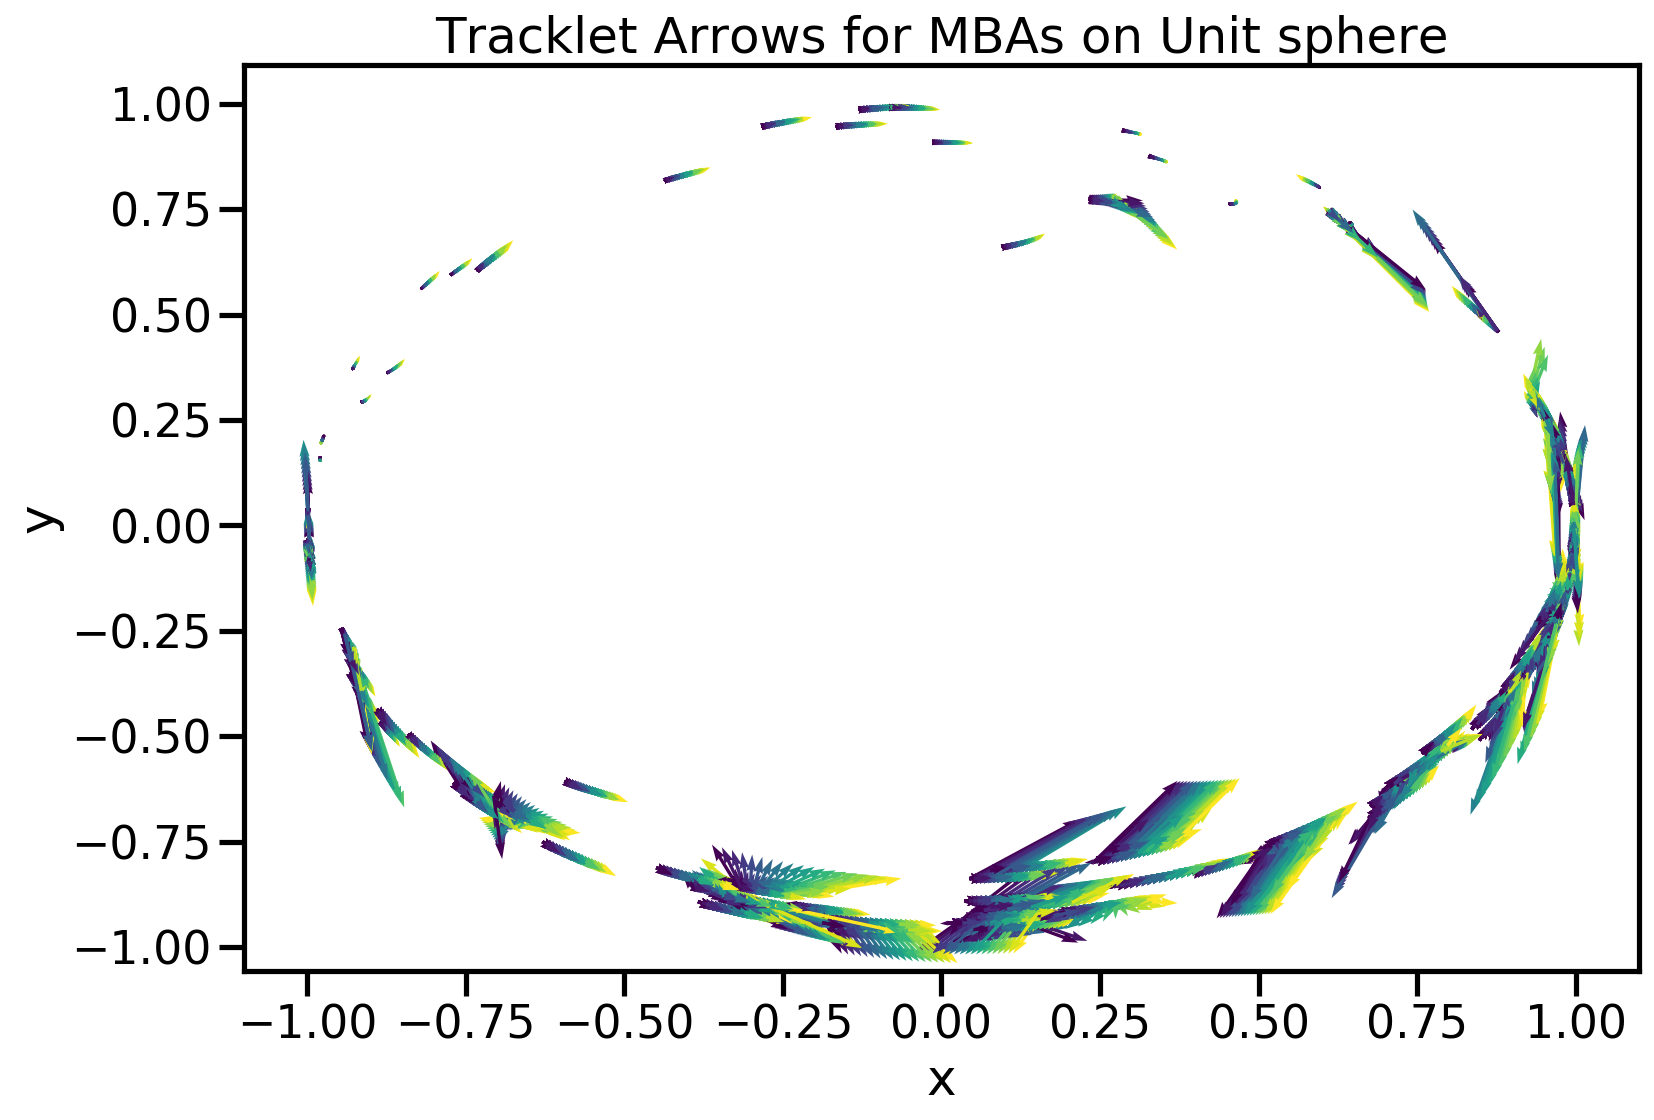

In [64]:

plt.figure(dpi=150,figsize=(12,8))
plt.quiver(xarrow[:,0],xarrow[:,1],varrow[:,0],varrow[:,1],tarrow,scale=0.5)
plt.title("Tracklet Arrows for MBAs on Unit sphere")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

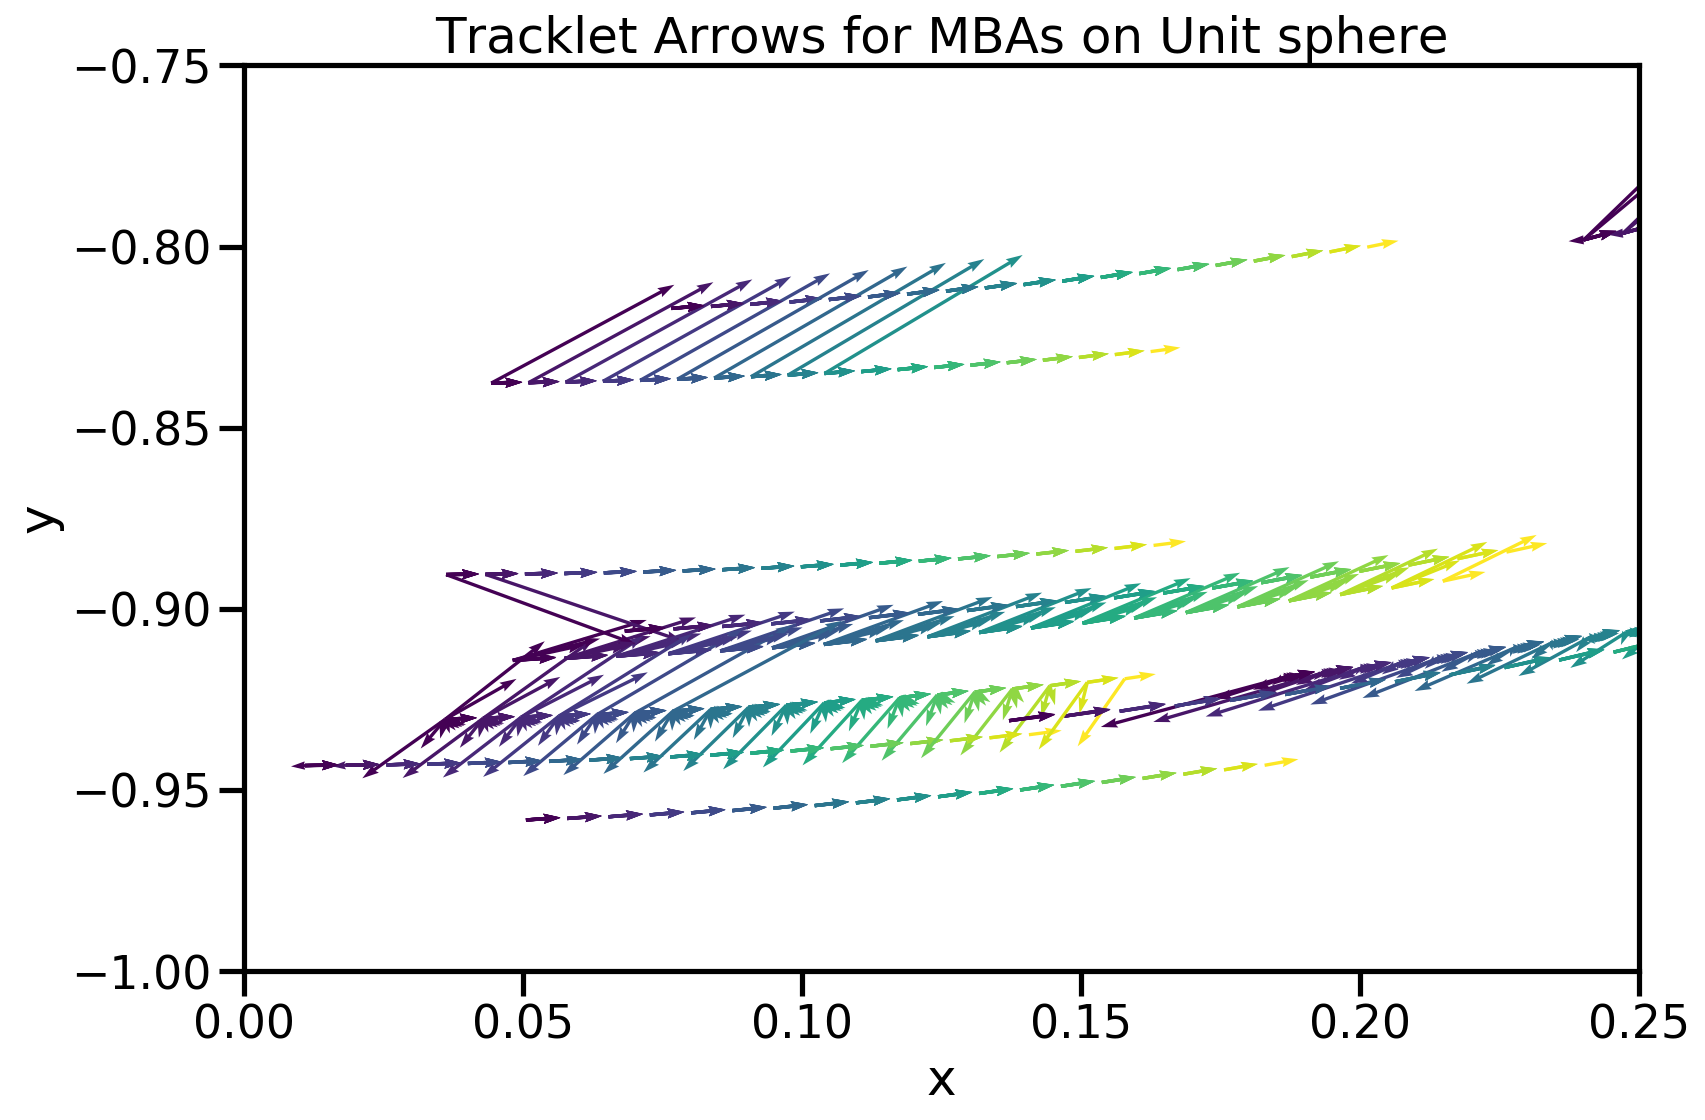

In [65]:
plt.figure(dpi=150,figsize=(12,8))
plt.quiver(xarrow[:,0],xarrow[:,1],varrow[:,0],varrow[:,1],tarrow,scale=0.3)
plt.xlim(0,0.25)
plt.ylim(-1,-0.75)
plt.title("Tracklet Arrows for MBAs on Unit sphere")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Now propagate the arrows to the same time (the center of the t array)

In [67]:
#[xp,dt] = mops.propagate_arrows_linear(xarrow,varrow,tarrow,df['time'].median())
[xp,vp,dt] = mops.propagate_arrows_celestial_sphere(xarrow,varrow,tarrow,df['time'].median())

In [87]:
xp;

In [88]:
dt;

In [70]:
#Scale arrow speed to unit lenght to facilitate clustering in 6D space
vpn=mops.unit_vector(vp)

In [71]:
# Create 6D array of tracklets
xpvp=np.hstack((xp,vpn))

In [72]:
xpvp

array([[-0.71138563,  0.6292991 ,  0.31291073,  0.6337792 ,  0.77141632,
        -0.05692785],
       [-0.40713117,  0.82997945,  0.38128509,  0.90926357,  0.37838611,
         0.17338892],
       [-0.04396745,  0.99082292,  0.12781548,  0.80818875, -0.02701761,
         0.58830349],
       ...,
       [-0.39229396, -0.83573398, -0.38425793,  0.9296975 , -0.32772429,
        -0.16810519],
       [ 0.95838521,  0.24777772,  0.14178853,  0.22905574, -0.31316135,
        -0.92166341],
       [-0.6547039 , -0.68597503, -0.31749183,  0.76663902, -0.60694471,
        -0.20948205]])

### Let's cluster!

In [113]:
# DBSCAN clustering parameters
eps=0.02
min_samples=10

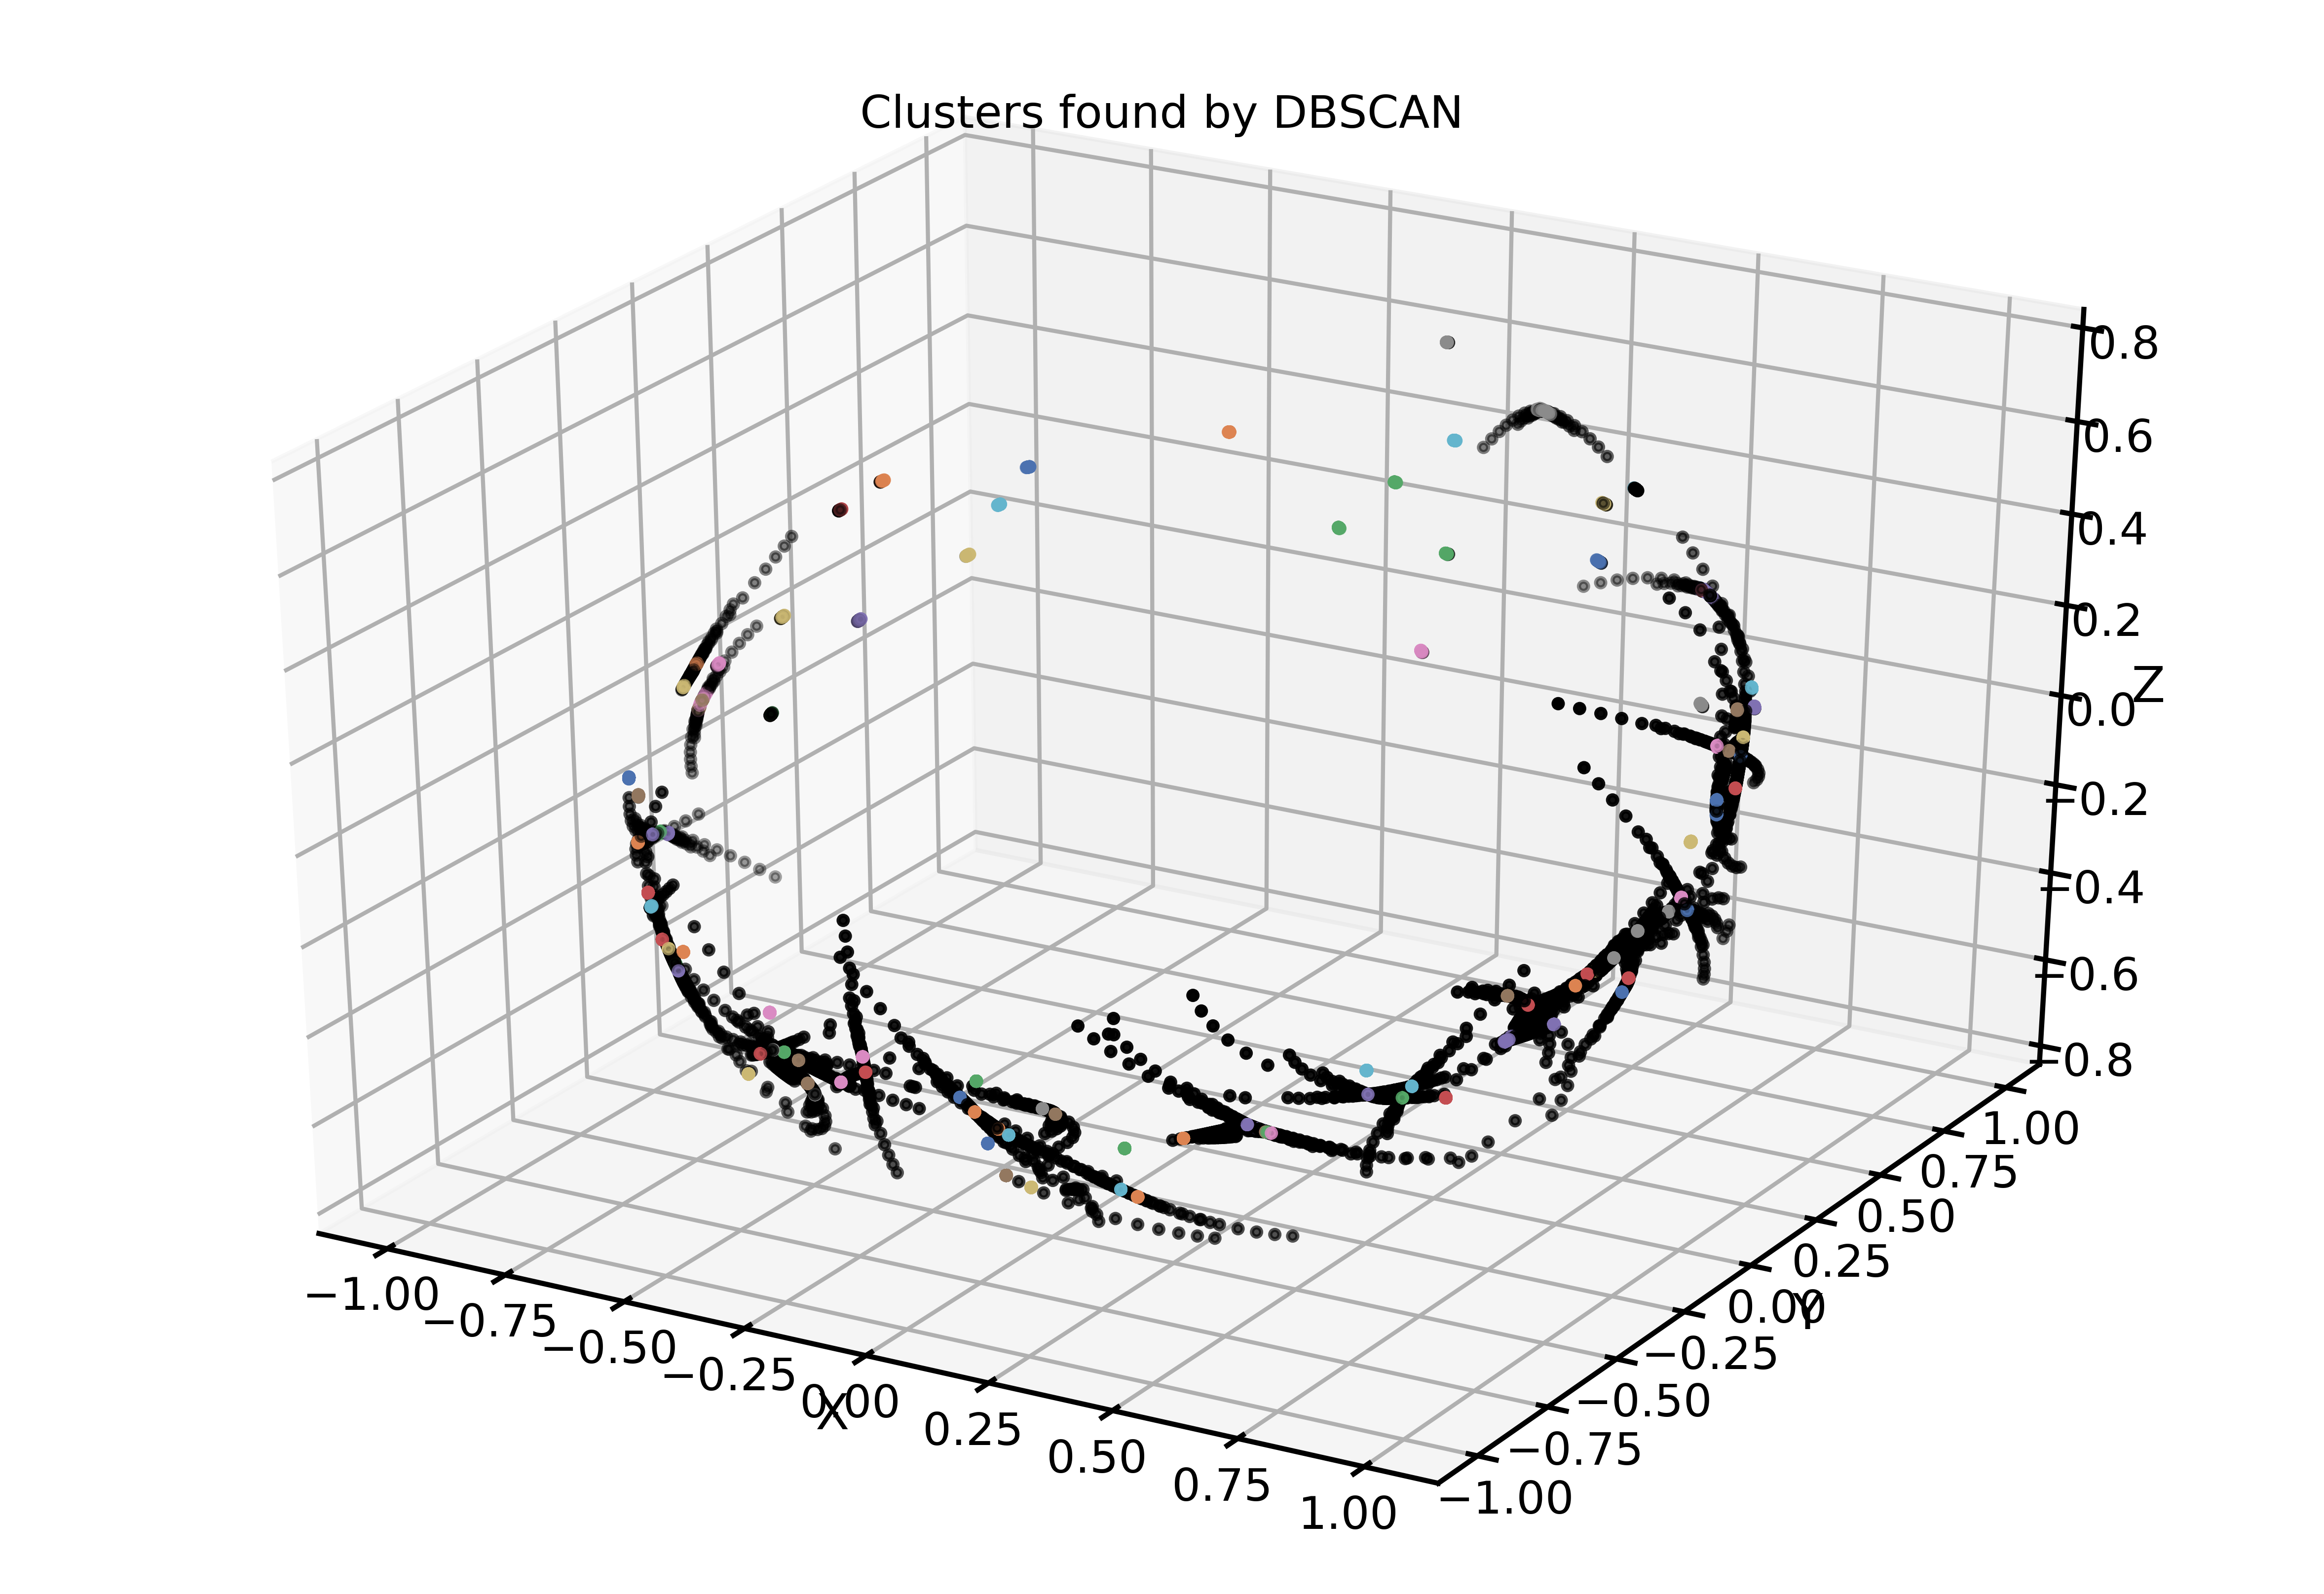

In [114]:
# Clustering in position space
plot_clusters3d(xpvp, [0,1,2], cluster.DBSCAN, (), {'eps':eps,'min_samples':min_samples})

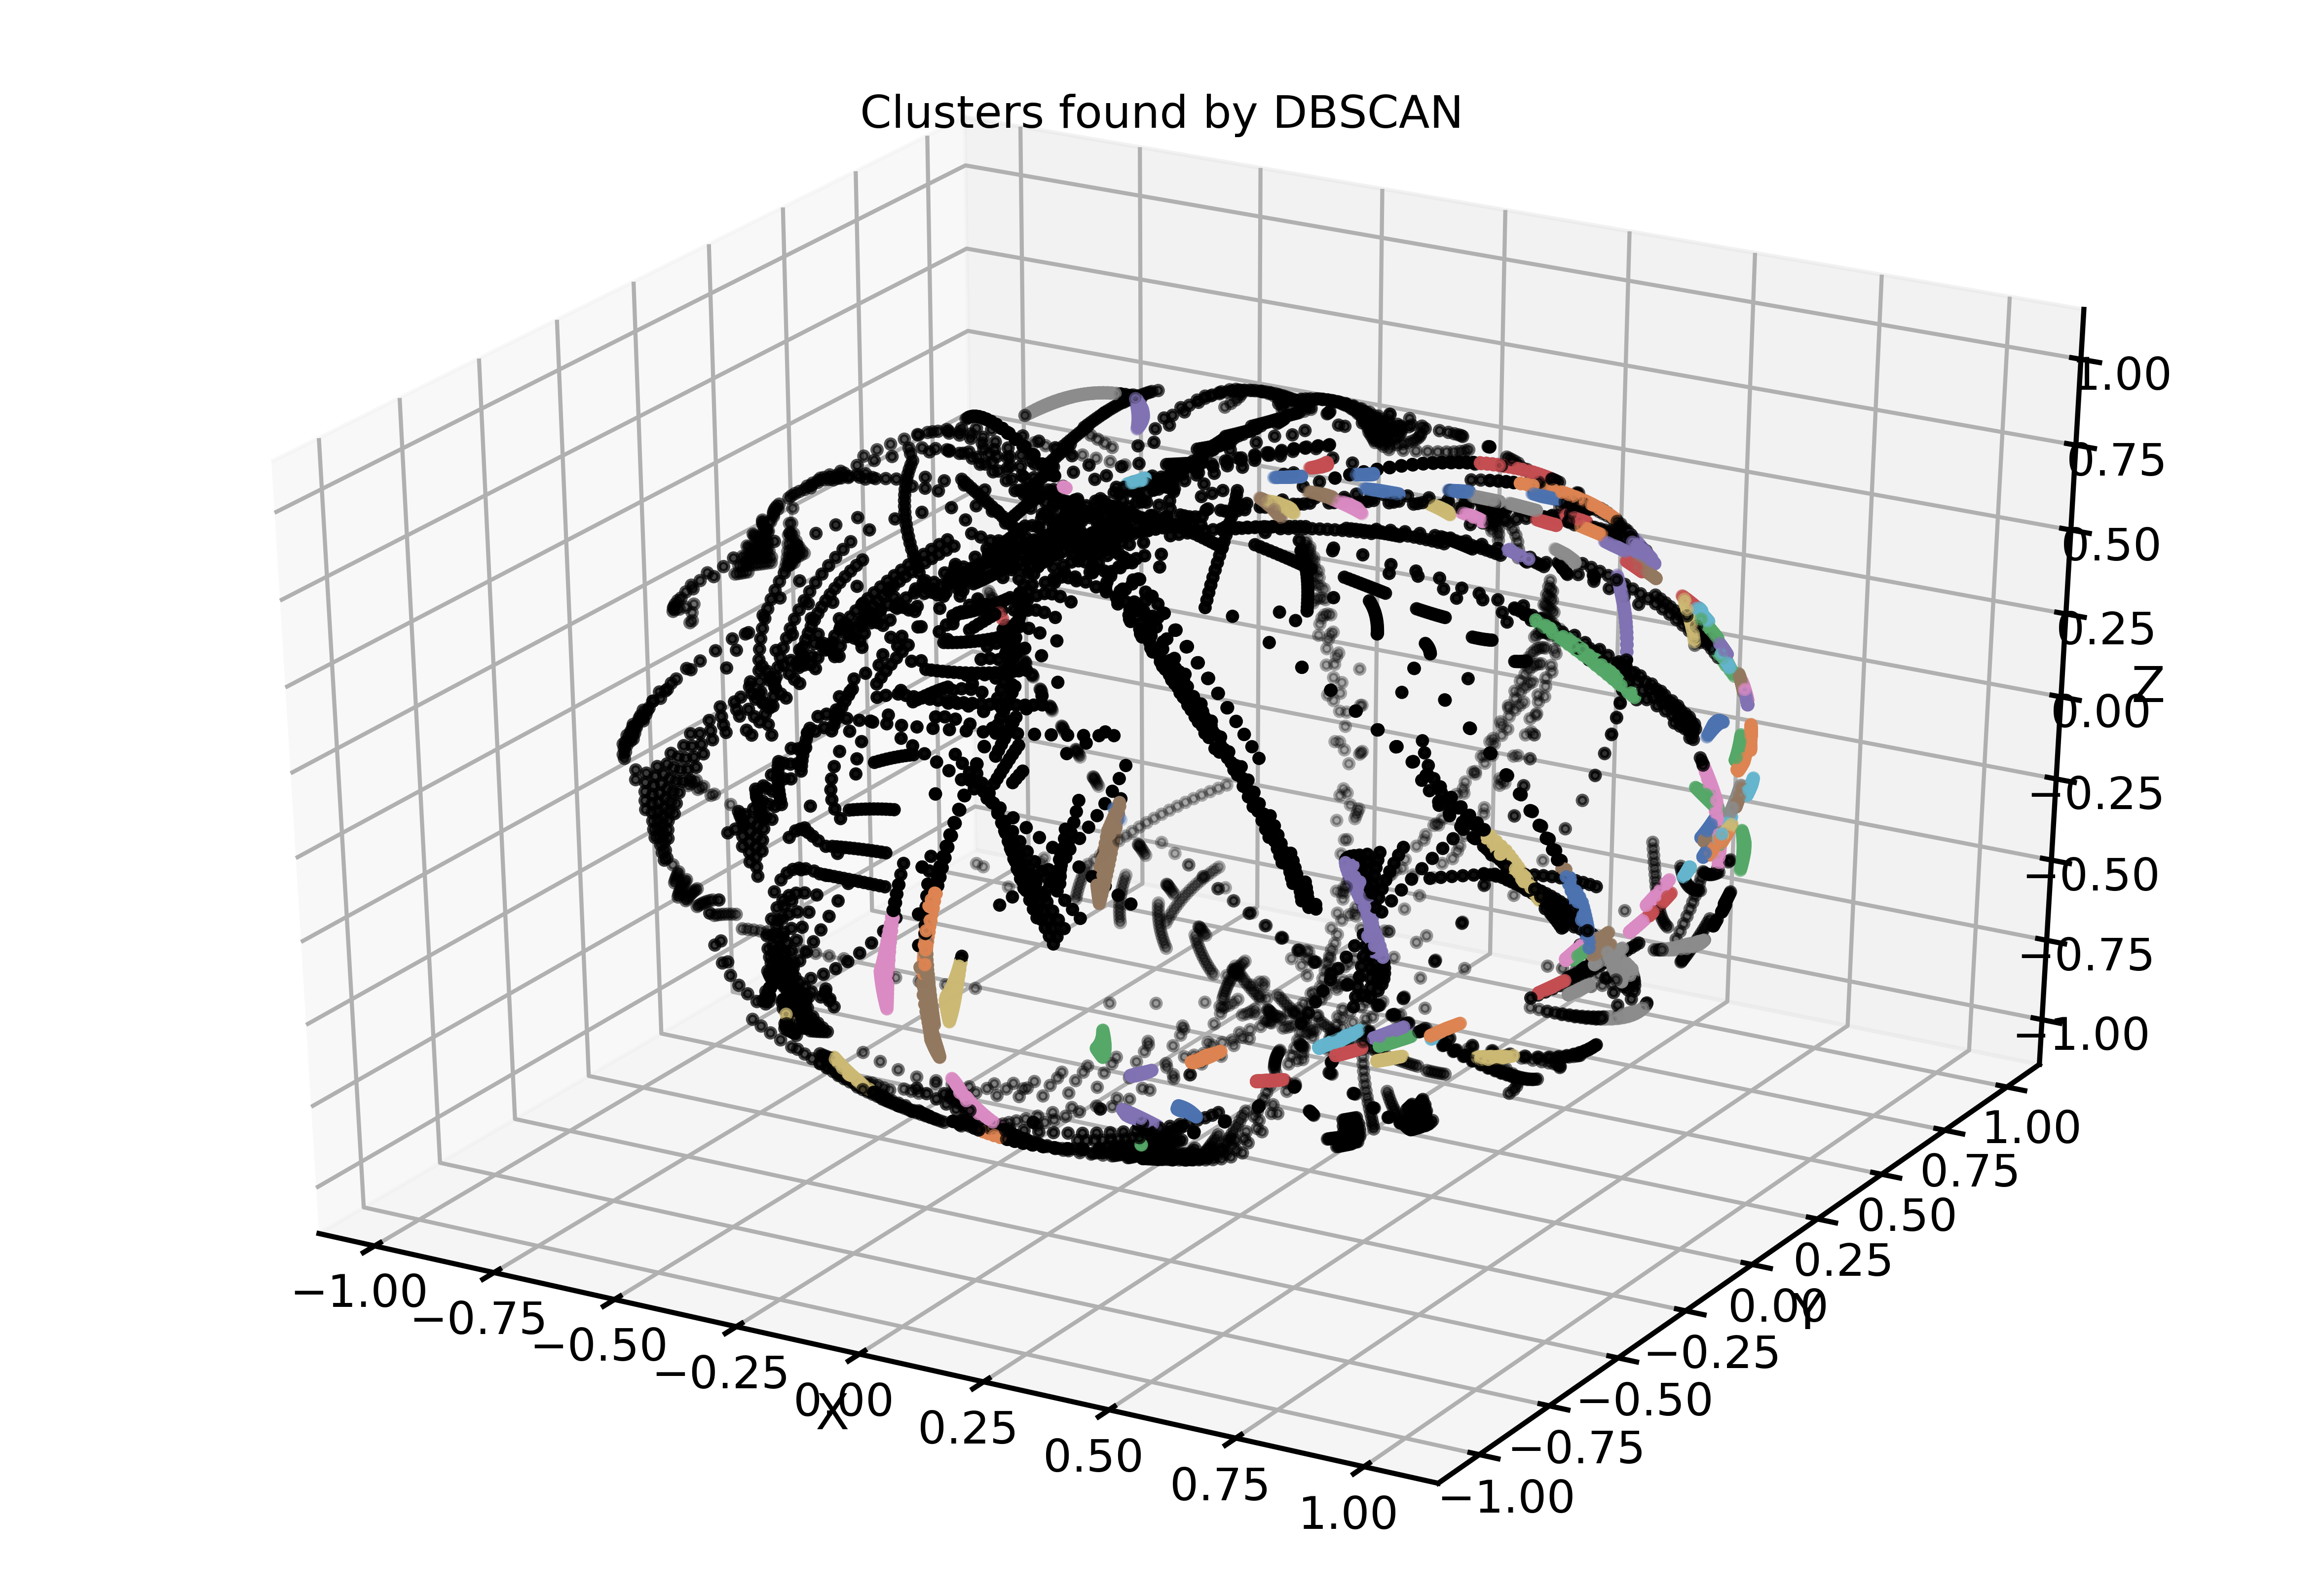

In [115]:
# Clustering in velocity space
plot_clusters3d(xpvp,[3,4,5], cluster.DBSCAN, (), {'eps':eps,'min_samples':min_samples})

### And in numbers ... 

In [116]:
db=cluster.DBSCAN(eps=eps,min_samples=min_samples).fit(xpvp)

In [117]:
# Number of objects observed 
metrics(df,goodpairs,db)[0]

100

In [118]:
# Number of clusters (including garbage), 
metrics(df,goodpairs,db)[1]

107

In [119]:
# number of perfect clusters (all obs of a given obj in one cluster) 
metrics(df,goodpairs,db)[2]

99

In [120]:
# number of pure clusters (obs of only one object in a cluster if not perfect)
metrics(df,goodpairs,db)[3]

0

In [121]:
# number of impure clusters (obs of multiple objects in one cluster)
metrics(df,goodpairs,db)[4]

8

In [122]:
# number of valid clusters (all obs of one objects mingled together with other observations)
metrics(df,goodpairs,db)[5]

3

In [123]:
#Completeness [%] (fraction of all observed objects that have been collected into clusters)
metrics(df,goodpairs,db)[6]

100.0

In [124]:
#Completeness perfect [%] 
metrics(df,goodpairs,db)[2]/metrics(df,goodpairs,db)[0]*100

99.0

In [125]:
#Missing objects
metrics(df,goodpairs,db)[7][0].compressed()

array([], dtype=float64)